In [82]:

import scipy.io
import torch
import importlib
import matplotlib.pyplot as plt
import numpy as np

import src.HyperParameters as hp 
import src.data as dt 
import src.model3 as Model 
import src.train as trainer

importlib.reload(hp)
importlib.reload(dt)
importlib.reload(Model)
importlib.reload(trainer)



<module 'src.train' from 'c:\\Users\\s420553\\Downloads\\PInn\\Friction-Factor-Estimation-PINN\\src\\train.py'>

In [83]:
def list_available_devices():
    devices = []
    if torch.cuda.is_available():
        devices.append('cuda')
    devices.append('cpu')
    devices.append('mps')

    return devices

def get_device_choice():
    devices = list_available_devices()
    print("Available devices:")
    for i, device in enumerate(devices):
        print(f"{i + 1}. {device}")
    while True:
        choice = input("Choose the device for model training (enter the corresponding number): ")
        if choice.isdigit() and 1 <= int(choice) <= len(devices):
            return devices[int(choice) - 1]
        print("Invalid choice. Please enter a valid device number.")

# Usage
device = get_device_choice()
print(f"Selected device: {device}")

Available devices:
1. cuda
2. cpu
3. mps
Selected device: cuda


In [84]:
# data = scipy.io.loadmat('/Users/ramtarun/Desktop/Cambridge/Indirect-Noise-in-Nozzles/Data/Data_PINN_subsonic_geom_linvelsup_f0-0.1.mat')
data=scipy.io.loadmat('C:\\Users\\s420553\\Downloads\\PInn\\Friction-Factor-Estimation-PINN\\Data\\Data_PINN_subsonic_geom_linvelsup_f0-0.1.mat')

In [85]:
PINN_model = Model.PINN(hp.input_size, hp.output_size, hp.hidden_size, hp.num_layers, hp.lda)
PINN_model.to(device, non_blocking=False)

PINN(
  (loss_function): MSELoss()
  (rnn): PhyGRU(
    (gru): GRU(2, 8, num_layers=2, batch_first=True, dropout=0.5)
    (output_layer): Linear(in_features=8, out_features=4, bias=True)
    (activation): Tanh()
  )
)

In [86]:
params = list(PINN_model.parameters())
# optimizer = torch.optim.Adam([{'params' : params[1::]},{'params' : params[-1], 'lr': hp.ff_learning_rate}], lr = hp.learning_rate, amsgrad = True)   
optimizer = torch.optim.Adam(params=params, lr = hp.learning_rate, amsgrad = True)   
# optimizer = torch.optim.LBFGS(params, hp.ff_learning_rate, 
#                               max_iter = hp.epochs, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-11, 
#                               tolerance_change = 1e-11, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')


In [87]:
device

'cuda'

In [88]:
inputs, targets, meanflow =  dt.DataPreprocessing(data, ff="0.01", device = device)
inputs.to(device)
targets.to(device)
meanflow.to(device)

N = inputs.shape[1]
train_loader, val_loader = dt.DataTransformer(inputs, targets, meanflow, TrainingSet=True)

meanflow.device

device(type='cuda', index=0)

Epoch 25/250 - Train Loss: 10.476576 Val Loss: 0.341510 f_train: 0.0651 f_test: 0.0595
Epoch 50/250 - Train Loss: 2.108230 Val Loss: 0.064172 f_train: 0.0021 f_test: -0.0056
Epoch 75/250 - Train Loss: 1.084651 Val Loss: 0.035265 f_train: -0.0052 f_test: -0.0038
Epoch 100/250 - Train Loss: 0.868773 Val Loss: 0.027150 f_train: 0.0080 f_test: 0.0184
Epoch 125/250 - Train Loss: 0.714953 Val Loss: 0.020807 f_train: 0.0183 f_test: 0.0107
Epoch 150/250 - Train Loss: 0.590570 Val Loss: 0.018259 f_train: 0.0192 f_test: 0.0215
Epoch 175/250 - Train Loss: 0.479472 Val Loss: 0.015365 f_train: 0.0305 f_test: 0.0411
Epoch 200/250 - Train Loss: 0.414817 Val Loss: 0.012863 f_train: 0.0328 f_test: 0.0250
Epoch 225/250 - Train Loss: 0.355146 Val Loss: 0.011345 f_train: 0.0375 f_test: 0.0445
Epoch 250/250 - Train Loss: 0.335627 Val Loss: 0.010296 f_train: 0.0340 f_test: 0.0315


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

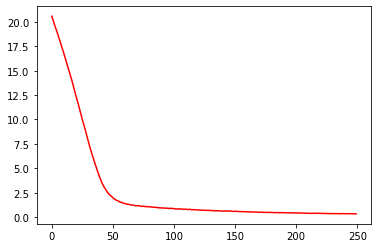

In [89]:
fval = [0.1  , 0.06 , 0.04, 0.01]

# for f in fval:
# ### Model 3
# batch_size = 32
# sequence_length = len(inputs) // batch_size
# # Reshape the input tensors within the DataLoader
# train_loader = []
# for batch in Train_loader:
#     input_data = batch.view(batch_size, sequence_length, 1)
#     train_loader.append(input_data)

train_loss, val_loss, f_train, f_test, f_dist = trainer.train(train_loader, val_loader, hp.epochs, optimizer, PINN_model, N)

with torch.no_grad():
    plt.figure() 
    plt.plot(train_loss.keys(), train_loss.values(), 'r-', label='Training Loss')
    plt.plot(val_loss.keys(), val_loss.values(), 'g-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure()
    plt.plot(f_train.keys(), f_train.values(), 'r-', label='Training Friction Factor')
    plt.plot(f_test.keys(), f_test.values(), 'g-', label='Validation Friction Factor')
    plt.xlabel('Epochs')
    plt.ylabel('Friction Factor')
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure()
